In [7]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

In [8]:
vector.register_awkward() 

In [9]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [10]:
!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0   132k      0  0:12:53  0:12:53 --:--:-- 1450k  0  0:21:06  0:00:18  0:20:48  104k 108k      0  0:15:50  0:00:59  0:14:51  110k3k      0  0:15:05  0:01:28  0:13:37  127k0   120k      0  0:14:12  0:06:42  0:07:30 92578   120k      0  0:14:15  0:07:02  0:07:13  114k  0     0   116k      0  0:14:44  0:09:21  0:05:23  112k   116k      0  0:14:44  0:09:22  0:05:22  111k     0   116k      0  0:14:44  0:09:33  0:05:11  103k    0  0:15:02  0:10:53  0:04:09 56166


In [1]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)


NameError: name 'uproot' is not defined

[{nMuons: 2, isCINT: True, isCMUL: False, isCMSL: True, ... 2, 0]}] 
 [{nMuonsGen: 2, Muon_GenE: [10.3, 20.7], ... Muon_GenMotherPDGCode: [443, 443]}] 

a


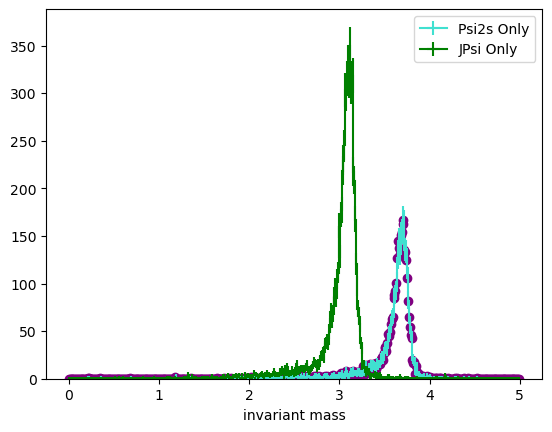

In [10]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit

vector.register_awkward() 

DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/nbPmKbcsJvZrjjx/291694/AnalysisResults.root' > run291694.mc.root
#!file *.root
#file = uproot.open("run291694.mc.root")
#file.keys()

#def data_url(run,is_mc):
#    basesrc="https://cernbox.cern.ch/remote.php/dav/public-files/VJZ5whMyF5Kxldd/dimuonData_LHC18m"
#    if is_mc==True:
#        basesrc+="MC"
#    return f"{basesrc}/{run}/AnalysisResults.root"

#def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
#    datatype="mc" if is_mc else "data"
#    print({dest},"/run",{run},".",{datatype},".root")
#    return f"{dest}/run{run}.{datatype}.root"

#def copy_cmd(run,is_mc,dest):
#    return f"curl '{data_url(run,is_mc)}' > {data_file_path(run,is_mc,dest)}"

def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#Gaussienne
def gauss(x,m,sigma,N):
    return N/(np.sqrt(2*math.pi)*sigma)*np.exp(-(x-m)**2/(2*sigma**2))

def getTracks_Psi(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 100443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def getTracks_Jpsi(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def scan(dataDescription1, dataDescription2, 
              hInvMass_Psi:hist.Hist, hInvMass_Jpsi:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch1, batch2 in zip(uproot.iterate(dataDescription1,
                                ["nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True), 
                             uproot.iterate(dataDescription2,
                                ["nMuonsGen", "Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 step_size="100 MB", report=True)):
        events=batch1[0] # batch[1] is the report info
        gen=batch2[0]
        print(events, "\n", gen, "\n")
        if len(events) < 1000:
            print("something is wrong",batch1[1], batch2[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks_Psi = getTracks_Psi(events, gen)
        tracks_Jpsi = getTracks_Jpsi(events, gen)
        
        pairs_Psi = ak.combinations(tracks_Psi, 2)
        one_Psi, two_Psi = ak.unzip(pairs_Psi)
        
        pairs_Jpsi = ak.combinations(tracks_Jpsi, 2)
        one_Jpsi, two_Jpsi = ak.unzip(pairs_Jpsi)
        
        #opposite_charge_cut = one.charge + two.charge == 0
        
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        invariant_mass_Psi = (one_Psi + two_Psi).mass
        invariant_mass_Jpsi = (one_Jpsi + two_Jpsi).mass

        hInvMass_Psi.fill(ak.flatten(invariant_mass_Psi))
        hInvMass_Jpsi.fill(ak.flatten(invariant_mass_Jpsi))

        print("a")

        if verbose:
            print(batch1[1], "\n", batch2[1])


vhInvMass_Psi = hist.Hist(hist.axis.Regular(bins=500,start=0,stop=5,name='invariant mass'))
vhInvMass_Jpsi = hist.Hist(hist.axis.Regular(bins=500,start=0,stop=5,name='invariant mass'))            
    
scan(dataDescription1=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
     dataDescription2=f"{BASEDIR}/run291694.{DATATYPE}.root:genTree",
     hInvMass_Psi=vhInvMass_Psi, hInvMass_Jpsi = vhInvMass_Jpsi,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta>0))

x_data=[]
y_data_Psi=[]
y_data_Jpsi = []

#print(vhInvMass)
#print(vhInvMass[22])
      
for i in range(0,5000,10):
    x_data.append(i/1000)
#print(x_data)


for i in vhInvMass_Psi:
      y_data_Psi.append(i)
#print(y_data)

for i in vhInvMass_Jpsi:
      y_data_Jpsi.append(i)
#print(y_data)

#plt.plot(x_data,y_data,'g')
vhInvMass_Psi.plot(color="turquoise", label="Psi2s Only")
vhInvMass_Jpsi.plot(color="green", label = "JPsi Only")
plt.scatter(x_data,y_data_Psi, color="purple")
plt.legend()
plt.show()

[ 3.6802609   0.07740212 29.0416964 ]


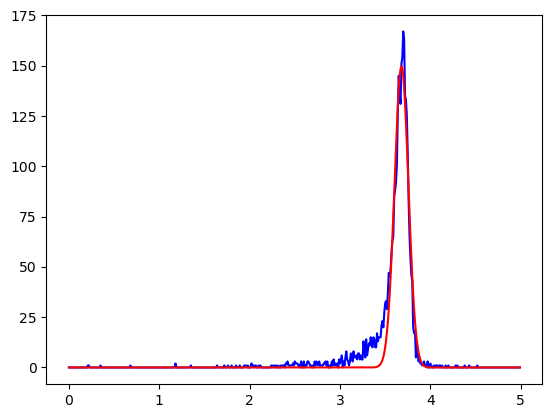

In [12]:
#fit avec gaussienne sur Psi
popt_gauss_Psi, pcov_gauss_Psi = curve_fit(gauss, x_data, y_data_Psi, p0=[3.5,0.1,1])
print(popt_gauss_Psi)
mu_fit_gauss_Psi=popt_gauss_Psi[0]
sigma_fit_gauss_Psi=popt_gauss_Psi[1]
N_fit_gauss_Psi=popt_gauss_Psi[2]
y_data_fit_gauss_Psi=gauss(x_data,mu_fit_gauss_Psi,sigma_fit_gauss_Psi,N_fit_gauss_Psi)
plt.plot(x_data,y_data_Psi,'b')
plt.plot(x_data,y_data_fit_gauss_Psi,'r')
plt.show()

/tmp/ipykernel_43325/892810671.py:39: RuntimeWarning: invalid value encountered in double_scalars
  A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
/tmp/ipykernel_43325/892810671.py:48: RuntimeWarning: invalid value encountered in double_scalars
  y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))


[ 3.68032474e+00  7.85414908e-02 -4.77718804e+00  2.16032763e+00
  1.03074349e+01  1.99184409e+00  1.48636444e+02]


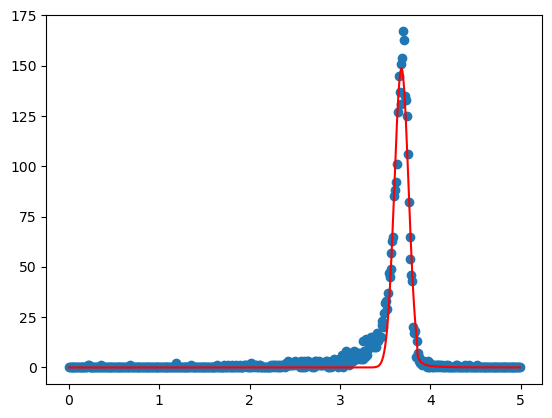

In [13]:
#fit avec crystall ball 2
#CrystalBall2(x, mu, sigma, alpha, alpha1, n, nbis, N)
alpha_fit_CB2_Psi = (3.3-mu_fit_gauss_Psi)/sigma_fit_gauss_Psi
alphabis_fit_CB2_Psi = (3.85-mu_fit_gauss_Psi)/sigma_fit_gauss_Psi
popt_CB2_Psi, pcov_CB2_Psi = curve_fit(CrystalBall2, x_data, y_data_Psi, p0=[mu_fit_gauss_Psi,sigma_fit_gauss_Psi,alpha_fit_CB2_Psi,alphabis_fit_CB2_Psi,1,1,N_fit_gauss_Psi])
print(popt_CB2_Psi)
x_moy_fit_CB2_Psi,sigma_fit_CB2_Psi,alpha_fit_CB2_Psi,alpha1_fit_CB2_Psi,n_fit_CB2_Psi,n1_fit_CB2_Psi,N_fit_CB2_Psi = popt_CB2_Psi
y_data_fit_Psi=CrystalBall2(x_data,x_moy_fit_CB2_Psi,sigma_fit_CB2_Psi,alpha_fit_CB2_Psi,alpha1_fit_CB2_Psi,n_fit_CB2_Psi,n1_fit_CB2_Psi,N_fit_CB2_Psi) #premier argument : variable indépendante x

plt.scatter(x_data,y_data_Psi)
plt.plot(x_data,y_data_fit_Psi,'r')
#plt.yscale("log")
plt.show()

[ 3.0878954   0.0755521  60.42060867]


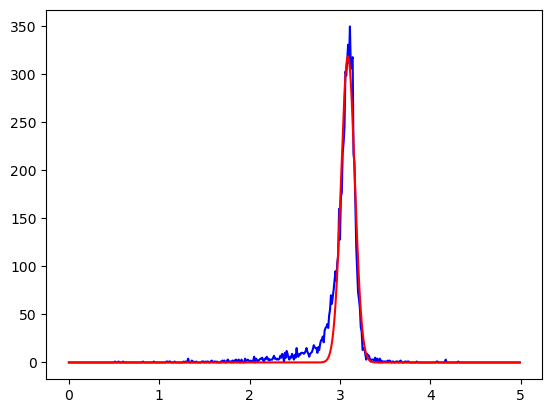

In [14]:
#fit avec gaussienne sur J-Psi
popt_gauss_Jpsi, pcov_gauss_Jpsi = curve_fit(gauss, x_data, y_data_Jpsi, p0=[3.,0.1,1])
print(popt_gauss_Jpsi)
mu_fit_gauss_Jpsi=popt_gauss_Jpsi[0]
sigma_fit_gauss_Jpsi=popt_gauss_Jpsi[1]
N_fit_gauss_Jpsi=popt_gauss_Jpsi[2]
y_data_fit_gauss_Jpsi=gauss(x_data,mu_fit_gauss_Jpsi,sigma_fit_gauss_Jpsi,N_fit_gauss_Jpsi)
plt.plot(x_data,y_data_Jpsi,'b')
plt.plot(x_data,y_data_fit_gauss_Jpsi,'r')
plt.show()

[ 3.08789751e+00  7.55521040e-02 -5.09044947e+00  1.48380515e+00
  1.01065855e+00  3.59970572e+00  3.20207698e+02]


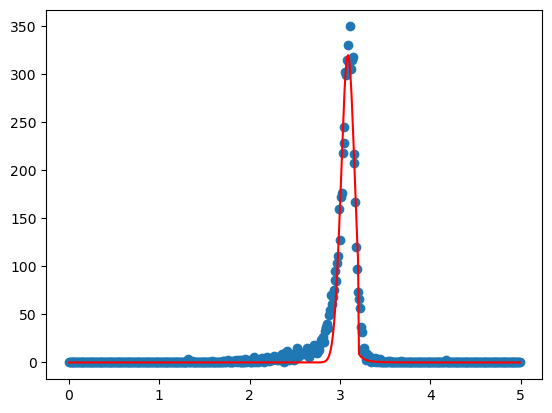

In [19]:
#fit avec crystall ball 2
#CrystalBall2(x, mu, sigma, alpha, alpha1, n, nbis, N)
alpha_fit_CB2_Jpsi = (2.7-mu_fit_gauss_Jpsi)/sigma_fit_gauss_Jpsi
alphabis_fit_CB2_Jpsi = (3.2-mu_fit_gauss_Jpsi)/sigma_fit_gauss_Jpsi
popt_CB2_Jpsi, pcov_CB2_Jpsi = curve_fit(CrystalBall2, x_data, y_data_Jpsi, p0=[mu_fit_gauss_Jpsi,sigma_fit_gauss_Jpsi,alpha_fit_CB2_Jpsi,alphabis_fit_CB2_Jpsi,1,1,N_fit_gauss_Jpsi])
print(popt_CB2_Jpsi)
x_moy_fit_CB2_Jpsi,sigma_fit_CB2_Jpsi,alpha_fit_CB2_Jpsi,alpha1_fit_CB2_Jpsi,n_fit_CB2_Jpsi,n1_fit_CB2_Jpsi,N_fit_CB2_Jpsi = popt_CB2_Jpsi
y_data_fit_Jpsi=CrystalBall2(x_data,x_moy_fit_CB2_Jpsi,sigma_fit_CB2_Jpsi,alpha_fit_CB2_Jpsi,alpha1_fit_CB2_Jpsi,n_fit_CB2_Jpsi,n1_fit_CB2_Jpsi,N_fit_CB2_Jpsi) #premier argument : variable indépendante x

plt.scatter(x_data,y_data_Jpsi)
plt.plot(x_data,y_data_fit_Jpsi,'r')
#plt.yscale("log")
plt.show()

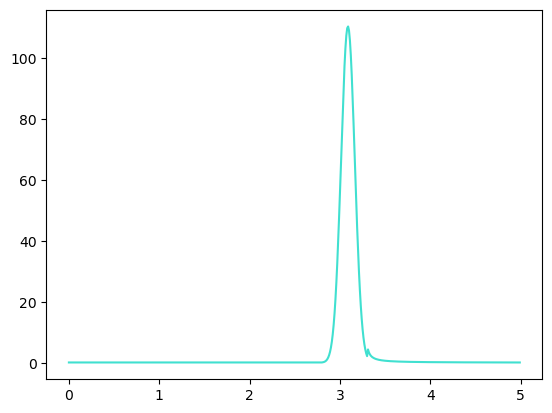

In [22]:
plt.plot(x_data,y_data_fit_Psi,color="turquoise")
plt.plot(x_data,y_data_fit_Jpsi,color="green")
#plt.yscale("log")
plt.show()